In [1]:
import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.inspection import permutation_importance 
import matplotlib.pyplot as plt 
import seaborn as sns 
import shap 
from lime.lime_tabular import LimeTabularExplainer

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
import geopandas as gpd

gdf = gpd.read_file("output.geojson")
df=gdf.copy()
df.head(5)

,S/N,station_name_geo,Address,Latitude,Longitude,State,distance_to_nearest_road_m,distance_to_nearest_road_km,roads_within_1000m,road_length_within_1000m,...,road_density_3000m,roads_within_5000m,road_length_within_5000m,road_density_5000m,lga_population,station_name_cleaned,station_name_csv,sales_volume,date,geometry
0,1,Yola,"Km 5, Yola-Numan Road, Jimeta, Adamawa State",9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,...,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,Yola,Yola (109),0.0,2015-01-02,POINT (12.19643 9.35923)
1,1,Yola,"Km 5, Yola-Numan Road, Jimeta, Adamawa State",9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,...,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,Yola,Yola (109),0.0,2015-01-03,POINT (12.19643 9.35923)
2,1,Yola,"Km 5, Yola-Numan Road, Jimeta, Adamawa State",9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,...,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,Yola,Yola (109),0.0,2015-01-05,POINT (12.19643 9.35923)
3,1,Yola,"Km 5, Yola-Numan Road, Jimeta, Adamawa State",9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,...,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,Yola,Yola (109),0.0,2015-01-06,POINT (12.19643 9.35923)
4,1,Yola,"Km 5, Yola-Numan Road, Jimeta, Adamawa State",9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,...,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,Yola,Yola (109),0.0,2015-01-07,POINT (12.19643 9.35923)


In [3]:
# Drop Non-ML Columns 
df = df.drop(columns=[ 
"S/N", 
"station_name_cleaned", 
"station_name_csv", 
"Address", 
"geometry",
"date",
# "distance_to_nearest_road_m",
# "distance_to_nearest_road_km"
], errors="ignore")

In [4]:
# # Handle Date (explicit & simple) 
# df["date"] = pd.to_datetime(df["date"], errors="coerce") 
# df["year"] = df["date"].dt.year 
# df["month"] = df["date"].dt.month 
# df["day"] = df["date"].dt.day 
# df["dayofweek"] = df["date"].dt.dayofweek 
# df = df.drop(columns=["date"])

In [5]:
df.isna().sum()

station_name_geo                    0
Latitude                            0
Longitude                           0
State                               0
distance_to_nearest_road_m     119064
distance_to_nearest_road_km    119064
roads_within_1000m                  0
road_length_within_1000m            0
road_density_1000m                  0
roads_within_3000m                  0
road_length_within_3000m            0
road_density_3000m                  0
roads_within_5000m                  0
road_length_within_5000m            0
road_density_5000m                  0
lga_population                 104544
sales_volume                       78
dtype: int64

In [6]:
# df.dropna(subset=['distance_to_nearest_road_m','distance_to_nearest_road_km','lga_population','sales_volume']).reset_index(drop=True)
df.dropna().reset_index(drop=True)
df.isna().sum()

station_name_geo                    0
Latitude                            0
Longitude                           0
State                               0
distance_to_nearest_road_m     119064
distance_to_nearest_road_km    119064
roads_within_1000m                  0
road_length_within_1000m            0
road_density_1000m                  0
roads_within_3000m                  0
road_length_within_3000m            0
road_density_3000m                  0
roads_within_5000m                  0
road_length_within_5000m            0
road_density_5000m                  0
lga_population                 104544
sales_volume                       78
dtype: int64

In [7]:
# Assuming df is your DataFrame (without geometry column)
print(f"Original shape: {df.shape}")

# Step 1: Convert all empty strings to NaN
df_clean = df.replace('', np.nan)

# Step 2: Also convert other common null representations
null_patterns = ['null', 'NULL', 'None', 'none', 'NA', 'na', 'N/A', 'n/a', 'missing', 'Missing']
df_clean = df_clean.replace(null_patterns, np.nan)

# Step 3: Drop rows with ANY NaN values
df_clean = df_clean.dropna()

print(f"Cleaned shape: {df_clean.shape}")
print(f"Dropped {len(df) - len(df_clean)} rows")
print(f"Kept {len(df_clean)} rows ({100*len(df_clean)/len(df):.1f}%)")

Original shape: (418176, 17)
Cleaned shape: (220659, 17)
Dropped 197517 rows
Kept 220659 rows (52.8%)


In [17]:
# Target & Features 
y = df_clean["sales_volume"] 
X = df_clean.drop(columns=["sales_volume"])

In [18]:
# Separate Numeric & Categorical 
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns 
categorical_cols = X.select_dtypes(include=["object"]).columns 
print("Numeric:", list(numeric_cols)) 
print("Categorical:", list(categorical_cols)) 

Numeric: ['Latitude', 'Longitude', 'distance_to_nearest_road_m', 'distance_to_nearest_road_km', 'road_length_within_1000m', 'road_density_1000m', 'road_length_within_3000m', 'road_density_3000m', 'road_length_within_5000m', 'road_density_5000m', 'lga_population']
Categorical: ['station_name_geo', 'State']


In [19]:
df.head()

,station_name_geo,Latitude,Longitude,State,distance_to_nearest_road_m,distance_to_nearest_road_km,roads_within_1000m,road_length_within_1000m,road_density_1000m,roads_within_3000m,road_length_within_3000m,road_density_3000m,roads_within_5000m,road_length_within_5000m,road_density_5000m,lga_population,sales_volume
0,Yola,9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,1.741464e+06,5470970,1.369558e+09,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,0.0
1,Yola,9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,1.741464e+06,5470970,1.369558e+09,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,0.0
2,Yola,9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,1.741464e+06,5470970,1.369558e+09,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,0.0
3,Yola,9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,1.741464e+06,5470970,1.369558e+09,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,0.0
4,Yola,9.359231,12.196428,Adamawa,0.00001,1.023151e-08,5470970,1.369558e+09,1.741464e+06,5470970,1.369558e+09,193495.982002,5470970,1.369558e+09,69658.553521,285015.9596,0.0


In [20]:
# Encode Categorical Variables (NO pipeline) 
 
ohe = OneHotEncoder( 
    handle_unknown="ignore", 
    sparse=False 
) 
 
X_cat = ohe.fit_transform(X[categorical_cols]) 
cat_feature_names = ohe.get_feature_names_out(categorical_cols) 
 
X_cat_df = pd.DataFrame( 
    X_cat, 
    columns=cat_feature_names, 
    index=X.index 
) 
 


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


In [21]:
# Scale Numeric Features 
 
scaler = StandardScaler() 
 
X_num_scaled = scaler.fit_transform(X[numeric_cols]) 
 
X_num_df = pd.DataFrame( 
    X_num_scaled, 
    columns=numeric_cols, 
    index=X.index 
) 
 


In [22]:
# Combine Features (Fully Explicit) 
 
X_final = pd.concat([X_num_df, X_cat_df], axis=1) 
 
print(X_final.shape)

(220659, 102)


In [23]:
#Train / Test Split 
X_train, X_test, y_train, y_test = train_test_split( 
X_final, 
y, 
test_size=0.2, 
random_state=42 
) 

In [25]:
df_clean.isna().sum()

station_name_geo               0
Latitude                       0
Longitude                      0
State                          0
distance_to_nearest_road_m     0
distance_to_nearest_road_km    0
roads_within_1000m             0
road_length_within_1000m       0
road_density_1000m             0
roads_within_3000m             0
road_length_within_3000m       0
road_density_3000m             0
roads_within_5000m             0
road_length_within_5000m       0
road_density_5000m             0
lga_population                 0
sales_volume                   0
dtype: int64

In [26]:
#Linear Regression 
lin_reg = LinearRegression() 
lin_reg.fit(X_train, y_train) 
y_pred_lr = lin_reg.predict(X_test) 

#Metrics 
print("Linear Regression") 
print("R2:", r2_score(y_test, y_pred_lr)) 
print("MAE:", mean_absolute_error(y_test, y_pred_lr)) 
print("RMSE:", mean_squared_error(y_test, y_pred_lr)) 

Linear Regression
R2: 0.22584633585674085
MAE: 4534.934261137043
RMSE: 38141192.90453506


In [27]:
# Lasso Regression 
lasso = Lasso(alpha=0.01, max_iter=5000) 
lasso.fit(X_train, y_train) 
y_pred_lasso = lasso.predict(X_test) 

#Metrics 
print("\nLasso Regression") 
print("R2:", r2_score(y_test, y_pred_lasso)) 
print("MAE:", mean_absolute_error(y_test, y_pred_lasso)) 
print("RMSE:", mean_squared_error(y_test, y_pred_lasso, squared=False))

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.065e+12, tolerance: 8.795e+08



Lasso Regression
R2: 0.22594919984055362
MAE: 4541.022996268254
RMSE: 6175.445326169674


In [28]:
# Interpretability – Coefficients 
#Linear Regression 
coef_df = pd.DataFrame({ 
"feature": X_final.columns, 
"coefficient": lin_reg.coef_ 
}).sort_values("coefficient", key=abs, ascending=False) 
coef_df.head(20)

,feature,coefficient
5,road_density_1000m,-1.480542e+16
8,road_length_within_5000m,-1.244244e+16
86,station_name_geo_Yola,-8.463416e+15
4,road_length_within_1000m,-7.985267e+15
87,State_Adamawa,7.749148e+15
6,road_length_within_3000m,5.714379e+15
7,road_density_3000m,-5.294574e+15
82,station_name_geo_Oyo 3,2.938534e+15
9,road_density_5000m,2.873137e+15
91,State_Edo,2.498566e+15


In [29]:
#Lasso (feature selection) 
lasso_df = pd.DataFrame({ 
"feature": X_final.columns, 
"coefficient": lasso.coef_ 
}) 
lasso_selected = lasso_df[lasso_df["coefficient"] != 0].sort_values("coefficient", key=abs, ascending=False) 
lasso_selected.head(20) 

,feature,coefficient
65,station_name_geo_Ojodu,10692.653992
12,station_name_geo_Ado 1,8326.171789
62,station_name_geo_Ogbomosho 1,7279.810503
77,station_name_geo_Ondo Surulere,6047.421182
33,station_name_geo_Efon Alaye,-5851.286926
47,station_name_geo_Ile-Oluji 2,-5584.314706
48,station_name_geo_Ilesha 1,5278.815908
32,station_name_geo_Ede 2,-4987.479341
79,station_name_geo_Owo,4955.914865
66,station_name_geo_Ojoo Barracks,-4938.280577


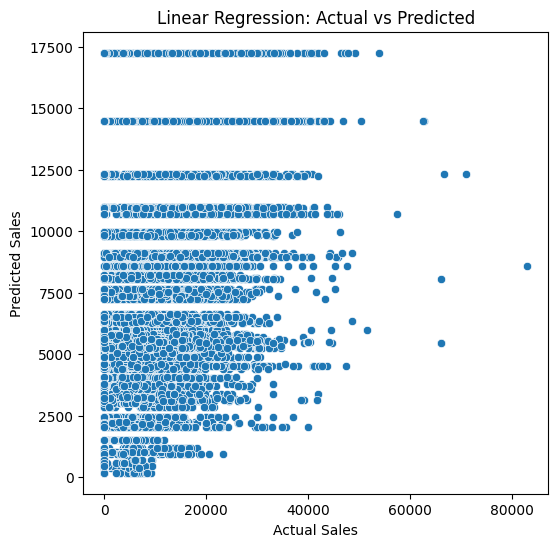

In [30]:
#Basic Diagnostic Plot 
plt.figure(figsize=(6, 6)) 
sns.scatterplot(x=y_test, y=y_pred_lr) 
plt.xlabel("Actual Sales") 
plt.ylabel("Predicted Sales") 
plt.title("Linear Regression: Actual vs Predicted") 
plt.show() 

In [31]:
# Permutation Feature Importance (Model-Agnostic) 
#This tells you how much performance drops when a feature is shuffled. 
from sklearn.inspection import permutation_importance 
 
perm = permutation_importance( 
    lin_reg, 
    X_test, 
    y_test, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=-1 
) 
 
perm_df = pd.DataFrame({ 
    "feature": X_final.columns, 
    "importance": perm["importances_mean"] 
}).sort_values("importance", ascending=False) 
 
perm_df.head(20) 

,feature,importance
86,station_name_geo_Yola,4.006597e+22
87,State_Adamawa,3.358863e+22
3,distance_to_nearest_road_km,7.438146e+21
100,State_Oyo,4.773602e+21
82,station_name_geo_Oyo 3,4.422521e+21
96,State_Niger,3.637350e+21
91,State_Edo,3.346077e+21
90,State_Delta,3.162833e+21
27,station_name_geo_Asaba,3.106697e+21
30,station_name_geo_Benin,2.623862e+21


In [32]:
# Create SHAP explainer 
import shap 
explainer = shap.LinearExplainer( 
lin_reg, 
X_train, 
feature_names=X_final.columns 
)

In [33]:
# Compute SHAP values 
shap_values = explainer(X_test) 

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


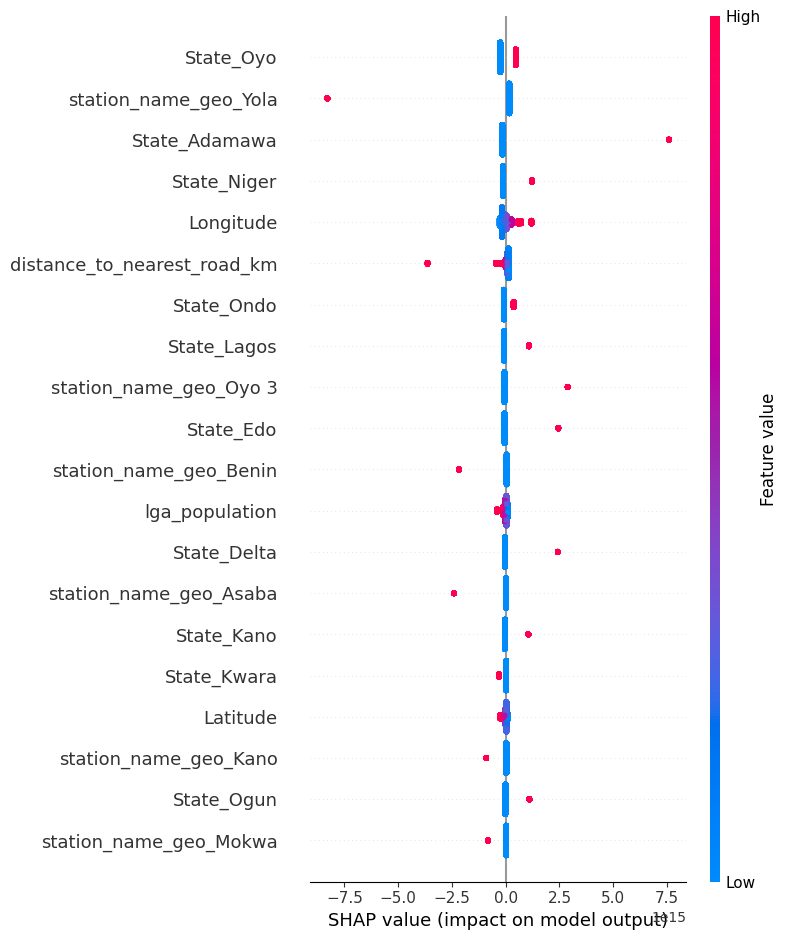

In [34]:
# Global importance (summary plot) 
shap.summary_plot( 
shap_values, 
X_test, 
feature_names=X_final.columns 
)

# nterpretation: 
# ● Top features globally 
# ● Direction (red ↑, blue ↓) 
# ● Spread = variability across stations/dates 

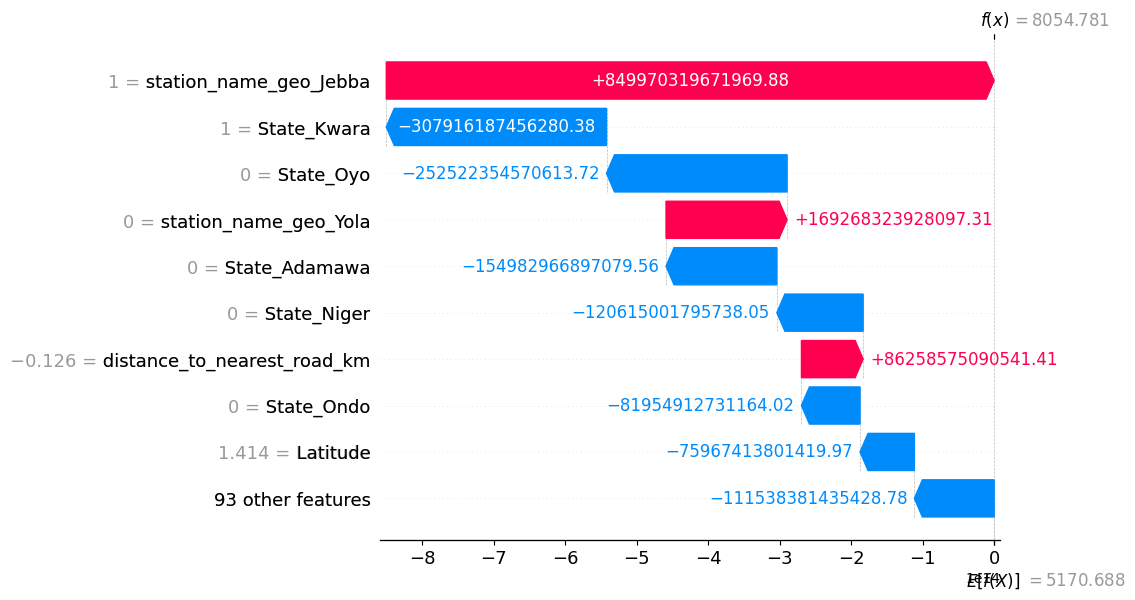

In [35]:
# Local explanation (single station) 
idx = 0  # choose any row 
shap.plots.waterfall(shap_values[idx]) 

# Interpretation: 
# ● Why THIS prediction is high/low 
# ● Perfect for case studies in a thesis 

In [36]:
# Create LIME explainer 
from lime.lime_tabular import LimeTabularExplainer 
 
lime_explainer = LimeTabularExplainer( 
    training_data=X_train.values, 
    feature_names=X_final.columns.tolist(), 
    mode="regression", 
    discretize_continuous=True, 
    random_state=42 
) 

In [37]:
# Prediction function (IMPORTANT) 
def lime_predict_fn(x): 
    return lin_reg.predict(x)

In [38]:
# Explain a single prediction 
idx = 0  # index in X_test 
 
lime_exp = lime_explainer.explain_instance( 
    X_test.iloc[idx].values, 
    lime_predict_fn, 
    num_features=10 
) 

X does not have valid feature names, but LinearRegression was fitted with feature names


In [39]:
# Display explanation 
lime_exp.show_in_notebook() 
 

# Interpretation: 
# ● “Feature X increases prediction by Y” 
# ● Very intuitive for non-technical stakeholders 

In [40]:
# SHAP vs LIME for the Same Point 
print("Actual:", y_test.iloc[idx]) 
print("Predicted:", lin_reg.predict(X_test.iloc[[idx]])[0]) 

Actual: 6700.0
Predicted: 8054.8125
